In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import butter, filtfilt
import scipy
#from PyEMD import EMD
import time
from scipy.signal import medfilt
from scipy.signal import firwin, lfilter

from utils import print_signal_qrs, print_signal, calcul_f1, perf

In [2]:
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    low = cutoff / nyquist
    b, a = butter(order, low, btype='low')
    y = filtfilt(b, a, data)
    return y

def differentiate(data):
    return np.diff(data, prepend=data[0])

def squaring(data):
    return np.square(data)

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def preprocess_ecg(data, fs, low, up):
    high_passed_data = highpass_filter(data, up, fs)
    low_passed_data = lowpass_filter(high_passed_data, low, fs)
    differentiated_data = differentiate(low_passed_data)
    squared_data = squaring(differentiated_data)
    integrated_data = moving_window_integration(squared_data, int(0.0667 * fs))  # window size of 66.7 ms
    return integrated_data

In [28]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/108.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360  # Example sampling frequency
QRS = df["labels"].dropna().astype(int).tolist()

In [ ]:
df.sort_values('f1')

In [ ]:
x = 500
t = range(x)

plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(t, ecg_signal[:x])
plt.title('Original ECG Data')
plt.subplot(2, 1, 2)
plt.plot(t, cleaned_ecg[:x])
plt.title('Processed ECG Data')
plt.show()

In [5]:
def make_SPK(m_val):
    # SPK = 0.13 * M_VAL
    return 0.13 * m_val

def make_NPK(spk):
    # NPK = 0.1 * SPK
    return 0.1 * spk

def calcul_seuil(spk, npk):
    # SEUIL = 0.25 * SPK + 0.75 * NPK
    return 0.25 * spk + 0.75 * npk

def calcul_AVE_RR(list_frames):
    return sum(np.diff(list_frames[-10:]))/len(list_frames)

In [1]:
360 * 0.15

54.0

In [6]:
def detect_peaks(cleaned_ecg, distance=int(fs*0.15), no_peak_distance=300):

    last_max = -np.inf  # The most recent encountered maximum value
    last_max_pos = -1  # Position of the last_max in the array
    peaks = []  # Detected peaks positions
    peak_values = []  # Detected peaks values
    
    for i in range(len(cleaned_ecg)):
        current_value = cleaned_ecg[i]
        
        if current_value > last_max:
            last_max = current_value
            last_max_pos = i
        
        if current_value <= last_max / 2 or (i - last_max_pos >= no_peak_distance and last_max_pos != -1):
            if last_max_pos != -1:
                peaks.append(last_max_pos)
                peak_values.append(last_max)
            
            last_max = current_value
            last_max_pos = i
    
    peaks = np.array(peaks)
    peak_values = np.array(peak_values)
    
    refined_peaks = []
    i = 0
    while i < len(peaks):
        peak_group_start = i
        while i < len(peaks) - 1 and peaks[i + 1] - peaks[peak_group_start] < distance:
            i += 1
        peak_group_end = i
        
        if peak_group_start == peak_group_end:
            refined_peaks.append(peaks[i])
        else:
            # Select the peak with the maximum value in this group
            max_peak = peak_values[peak_group_start:peak_group_end+1].argmax()
            refined_peaks.append(peaks[peak_group_start + max_peak])
        
        i += 1
    
    return np.array(refined_peaks)

peaks = detect_peaks(cleaned_ecg)

In [7]:
def threshold_detection(cleaned_ecg, peaks, fs, initial_search_samples=300, long_peak_distance=400):
    M_VAL = np.max(cleaned_ecg[:initial_search_samples])
    
    SPK = 0.13 * M_VAL
    NPK = 0.1 * SPK
    THRESHOLD = 0.25 * SPK + 0.75 * NPK
    
    qrs_peaks = []
    noise_peaks = []
    qrs_buffer = []
    last_qrs_time = 0
    min_distance = int(fs * 0.33)
    
    for peak in peaks:
        peak_value = cleaned_ecg[peak]
        
        if peak_value > THRESHOLD:
            if qrs_peaks and (peak - qrs_peaks[-1] < min_distance):
                if peak_value > cleaned_ecg[qrs_peaks[-1]]:
                    qrs_peaks[-1] = peak
            else:
                qrs_peaks.append(peak)
                last_qrs_time = peak
            
            SPK = 0.25 * peak_value + 0.75 * SPK
            
            qrs_buffer.append(peak)
            if len(qrs_buffer) > 10:
                qrs_buffer.pop(0)
        else:
            noise_peaks.append(peak)
            NPK = 0.25 * peak_value + 0.75 * NPK
        
        THRESHOLD = 0.25 * SPK + 0.75 * NPK
        
        if peak - last_qrs_time > long_peak_distance:
            SPK *= 0.5
            THRESHOLD = 0.25 * SPK + 0.75 * NPK
            for lookback_peak in peaks:
                if last_qrs_time < lookback_peak < peak:
                    if cleaned_ecg[lookback_peak] > THRESHOLD:
                        qrs_peaks.append(lookback_peak)
                        SPK = 0.875 * SPK + 0.125 * cleaned_ecg[lookback_peak]
                        THRESHOLD = 0.25 * SPK + 0.75 * NPK
                        last_qrs_time = lookback_peak
                        break
        
        if len(qrs_buffer) > 1:
            rr_intervals = np.diff(qrs_buffer)
            mean_rr = np.mean(rr_intervals)
            if peak - last_qrs_time > 1.5 * mean_rr:
                SPK *= 0.5
                THRESHOLD = 0.25 * SPK + 0.75 * NPK
    
    return np.array(qrs_peaks)

In [36]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/108.csv') #207
ecg_signal = np.array(df["MLII"], dtype=np.float32)#[:1000]
fs = 360  # Example sampling frequency
QRS = df["labels"].dropna().astype(int).tolist()

In [35]:
cleaned_ecg = preprocess_ecg(ecg_signal, fs, 15, 5)
peaks = detect_peaks(cleaned_ecg)
qrs_indices = threshold_detection(cleaned_ecg, peaks, fs)
temp = perf(QRS, qrs_indices, 36)
temp

(1755, 72, 72, 0.9605911330049262)

signal de longueur: 1000


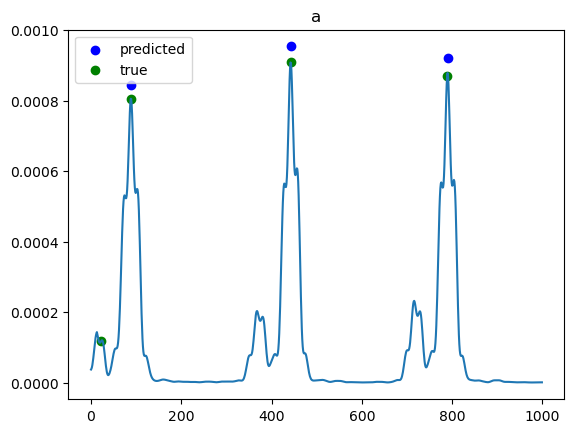

In [37]:
mini = 0
maxi = 1000
print_signal_qrs(cleaned_ecg[mini:maxi], 
                 [a - mini for a in qrs_indices if a < maxi and a > mini], 
                 [a - mini for a in QRS if a < maxi and a > mini], )

In [32]:
def print_signal_qrs(signal, qrs, true_qrs, mini = 0, maxi = 1, description = "a", other_list = []):
    if maxi == 1:
        maxi = len(signal)
    cut_qrs = [a - mini for a in qrs if a < maxi and a > mini]
    true_cut_qrs = [a - mini for a in true_qrs if a < maxi and a > mini]
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal[mini:maxi])
    plt.scatter(cut_qrs , [signal[i] * 1.05 for i in cut_qrs ], color='blue', label = 'predicted')
    plt.scatter(true_cut_qrs , [signal[i] for i in true_cut_qrs ], color='green', label = 'true')
    if other_list != []:
        plt.plot(other_list)
    plt.title(label= description)
    plt.legend()
    plt.show()

In [77]:
np.diff(QRS[1:Y+1])

NameError: name 'Y' is not defined

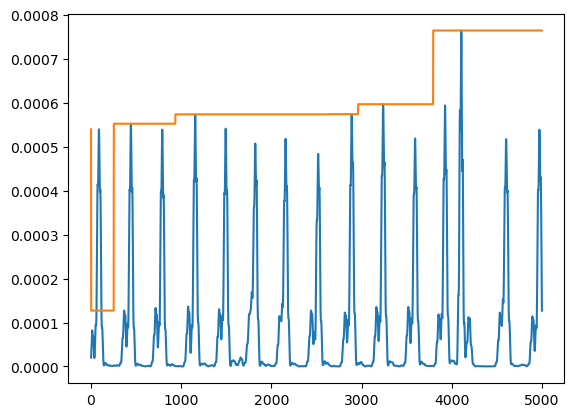

In [44]:
plt.figure()
plt.plot(cleaned_ecg[:5000])
plt.plot(list_seuil[:5000])
plt.show()

signal de longueur: 4000


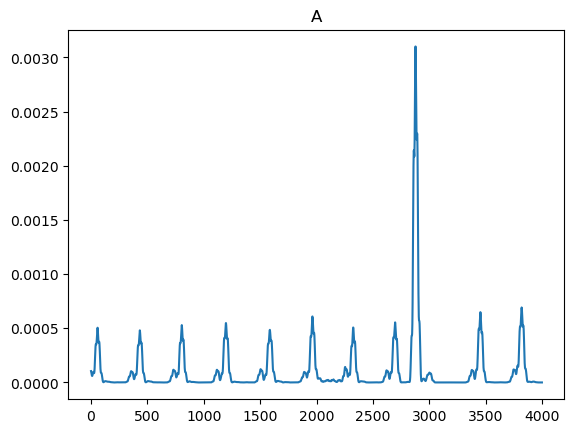

In [68]:
print_signal(cleaned_ecg[8000:12000])

signal de longueur: 650000


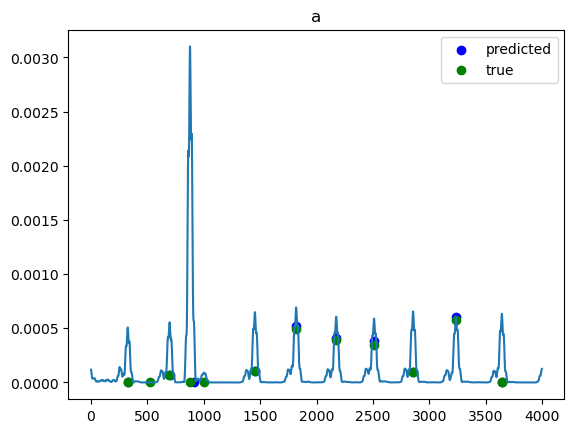

In [57]:
print_signal_qrs(cleaned_ecg, 
                 qrs_indices, 
                 QRS,
                 mini = 10000,
                 maxi = 14000)

In [28]:
def print_signal_qrs(signal, qrs, true_qrs, mini = 0, maxi = 1, description = "a"):
    if maxi == 1:
        maxi = len(signal)
    cut_qrs = [a - mini for a in qrs if a < maxi and a > mini]
    true_cut_qrs = [a - mini for a in true_qrs if a < maxi and a > mini]
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal[mini:maxi])
    plt.scatter(cut_qrs , [signal[i] * 1.05 for i in cut_qrs ], color='blue', label = 'predicted')
    plt.scatter(true_cut_qrs , [signal[i] for i in true_cut_qrs ], color='green', label = 'true')
    plt.title(label= description)
    plt.legend()
    plt.show()

In [10]:
if i < length - start:
                    M_VAL = np.max(cleaned_ecg[i - start:i+start])
                    SPK = make_SPK(M_VAL)
                    NPK = make_NPK(SPK)
                    SEUIL = calcul_seuil(SPK, NPK)

In [74]:
def seuil_dynamique(cleaned_ecg, fs):
    interval_max = 1.111*fs
    RR_interval = 9999
    start = 300 # fs * 3

    qrs_indices = [np.argmax(cleaned_ecg[:start])]
    sous_groupe = []

    A = int(fs//10)
    last_peak = 0

    M_VAL = np.max(cleaned_ecg[:start])
    SPK = make_SPK(M_VAL)
    NPK = make_NPK(SPK)
    SEUIL = calcul_seuil(SPK, NPK)
    list_seuil = []

    prctg = 0.4
    limite_suite = int(fs*0.15)
    i = qrs_indices[-1] + limite_suite
    last_peak = qrs_indices[-1]
    checkpoint = 0
    window_max = 250
    while i < len(cleaned_ecg[:]):
        #list_seuil.append(SEUIL)
        if cleaned_ecg[i] < M_VAL * 0.5:
            M_VAL = cleaned_ecg[last_peak]
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)

        if cleaned_ecg[i] >= SEUIL:
            M_VAL = max(cleaned_ecg[i:i+window_max])
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)

            last_peak = i + np.argmax(cleaned_ecg[i:i+window_max])
            qrs_indices.append(last_peak)

            RR_interval = calcul_AVE_RR(qrs_indices[-10:])
            list_seuil.extend([SEUIL] * (np.argmax(cleaned_ecg[i:i+window_max]) +  limite_suite))      

            i = last_peak +  limite_suite # int(RR_interval * prctg) #

        elif (i - last_peak >= interval_max or i - last_peak >= RR_interval*1.5) and i - checkpoint >= 200:
            temp_seuil = calcul_seuil(SPK/2, make_NPK(SPK/2))
            #print(f"{last_peak}: C  // i = {i}")
            for j in range(last_peak + limite_suite, i):
                if cleaned_ecg[j] >= temp_seuil:
                    last_peak = i + np.argmax(cleaned_ecg[i:i+window_max])
                    qrs_indices.append(last_peak)

                    RR_interval = calcul_AVE_RR(qrs_indices[-10:])
                    list_seuil.extend([SEUIL] * (np.argmax(cleaned_ecg[i:i+window_max]) +  limite_suite)  )  
                    i = last_peak +  limite_suite # int(RR_interval * prctg) #
                    break
                    
            checkpoint = i
        i += 1  
    return qrs_indices, list_seuil

qrs_indices, list_seuil = seuil_dynamique(cleaned_ecg, fs)
perf(QRS, qrs_indices, 36)

TP = 1762, FP = 91, FN = 91, F1_score = 0.9508904479222882


In [ ]:
def seuil_dynamique(sig, fs):

    cleaned_ecg = preprocess_ecg(sig, fs)

    interval_max = 1.111*fs
    RR_interval = 9999
    start = 800 # fs * 3

    qrs_indices = [np.argmax(cleaned_ecg[:start])]
    last_peak = 0

    M_VAL = np.max(cleaned_ecg[:start])
    SPK = make_SPK(M_VAL)
    NPK = make_NPK(SPK)
    SEUIL = calcul_seuil(SPK, NPK)
        
    prctg = 0.4
    limite_suite = int(fs*0.15)
    i = qrs_indices[-1] + limite_suite
    last_peak = qrs_indices[-1]
    while i < len(cleaned_ecg):
        if cleaned_ecg[i] < M_VAL * 0.5:
            last_peak = i + np.argmax(cleaned_ecg[i:i+fs])
            
            M_VAL = cleaned_ecg[last_peak]
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)
            
            RR_interval = calcul_AVE_RR(qrs_indices[-10:])
            qrs_indices.append(last_peak)
            i = last_peak +  limite_suite # int(RR_interval * prctg) #
            
        elif cleaned_ecg[i] >= SEUIL:
            M_VAL = max(cleaned_ecg[i:i+100])
            SPK = make_SPK(M_VAL)
            NPK = make_NPK(SPK)
            SEUIL = calcul_seuil(SPK, NPK)
            
            last_peak = i + np.argmax(cleaned_ecg[i:i+limite_suite])
            qrs_indices.append(last_peak)
            
            RR_interval = int((qrs_indices[-2] - qrs_indices[-3])*prctg)
            #RR_interval = calcul_AVE_RR(qrs_indices[-10:])
            i = last_peak +  limite_suite # int(RR_interval * prctg) #
            
            """if len(qrs_indices) > 2:
                RR_interval = int((qrs_indices[-2] - qrs_indices[-3])*prctg) # calcul_AVE_RR(qrs_indices[-10:])
                i = v + int((qrs_indices[-2] - qrs_indices[-3])*prctg)"""        
                
        elif len(qrs_indices) > 3 and (i - last_peak >= interval_max or i - last_peak >= RR_interval):
            temp_seuil = calcul_seuil(SPK/2, make_NPK(SPK/2))
            for j in range(last_peak + limite_suite, i):
                if cleaned_ecg[j] >= temp_seuil:
                    last_peak = np.argmax(cleaned_ecg[i:i+100])
                    qrs_indices.append(last_peak)
                    RR_interval = int((qrs_indices[-2] - qrs_indices[-3])*prctg) # calcul_AVE_RR(qrs_indices[-10:]) # int((qrs_indices[-2] - qrs_indices[-3])*prctg) # calcul_AVE_RR(qrs_indices[-10:])"""
        i += 1    
    
    return qrs_indices